# Predict Future Sales

## Description

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zafermesutblen","key":"995425ec3b85ccd5b3968c2fab0c6f1b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 224MB/s]


In [5]:
!unzip competitive-data-science-predict-future-sales.zip

Archive:  competitive-data-science-predict-future-sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


In [6]:
import os

files_to_delete = ["item_categories.csv", "items.csv", "shops.csv"]

for file_name in files_to_delete:
    file_path = os.path.join(os.getcwd(), file_name)

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_name} deleted.")
    else:
        print(f"{file_name} not found.")

item_categories.csv deleted.
items.csv deleted.
shops.csv deleted.


In [7]:
!kaggle datasets download deepdivelm/predict-future-sales-eng-translation

Dataset URL: https://www.kaggle.com/datasets/deepdivelm/predict-future-sales-eng-translation
License(s): unknown
  0% 0.00/327k [00:00<?, ?B/s]
100% 327k/327k [00:00<00:00, 123MB/s]


In [8]:
!unzip predict-future-sales-eng-translation.zip

Archive:  predict-future-sales-eng-translation.zip
  inflating: categories.csv          
  inflating: items.csv               
  inflating: shops.csv               


In [9]:
!pip install shap

In [10]:
!pip install lightgbm

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from itertools import product
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import lightgbm as lgb
import shap
from plotly.subplots import make_subplots

import gc
import re


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [12]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [13]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('categories.csv')
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

In [14]:
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


In [15]:
cats.head()

,category_name,category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [16]:
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


In [17]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [18]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [19]:
cats['split'] = cats['category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats = cats[['category_id','type', 'subtype']]

In [20]:
cats.head(10)

,category_id,type,subtype
0,0,PC,Headsets / Headphones
1,1,Accessories,PS2
2,2,Accessories,PS3
3,3,Accessories,PS4
4,4,Accessories,PSP
5,5,Accessories,PSVita
6,6,Accessories,XBOX 360
7,7,Accessories,XBOX ONE
8,8,Tickets (Digital),Tickets (Digital)
9,9,Delivery of goods,Delivery of goods


In [21]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.day_of_week

train['revenue'] = train.item_price.values * train.item_cnt_day.values
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,day_of_week,revenue
0,2013-01-02,0,59,22154,999.00,1.0,1,2013,2,999.00
1,2013-01-03,0,25,2552,899.00,1.0,1,2013,3,899.00
2,2013-01-05,0,25,2552,899.00,-1.0,1,2013,5,-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1,2013,6,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1,2013,1,1099.00


In [22]:
print('Entries by year-month')
train.groupby(['year', 'month'])['date'].nunique()

Entries by year-month


year  month
2013  1        31
      2        28
      3        31
      4        30
      5        31
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       31
2014  1        31
      2        28
      3        31
      4        30
      5        31
      6        30
      7        31
      8        31
      9        30
      10       31
      11       30
      12       31
2015  1        31
      2        28
      3        31
      4        30
      5        31
      6        30
      7        31
      8        31
      9        30
      10       31
Name: date, dtype: int64

In [23]:
sales_agg = train.groupby(['year', 'month', 'shop_id'])['revenue'].sum().reset_index()
sales_agg['shop_id'].value_counts()

,count
shop_id,
3,34
2,34
6,34
4,34
14,34
12,34
7,34
21,34
19,34


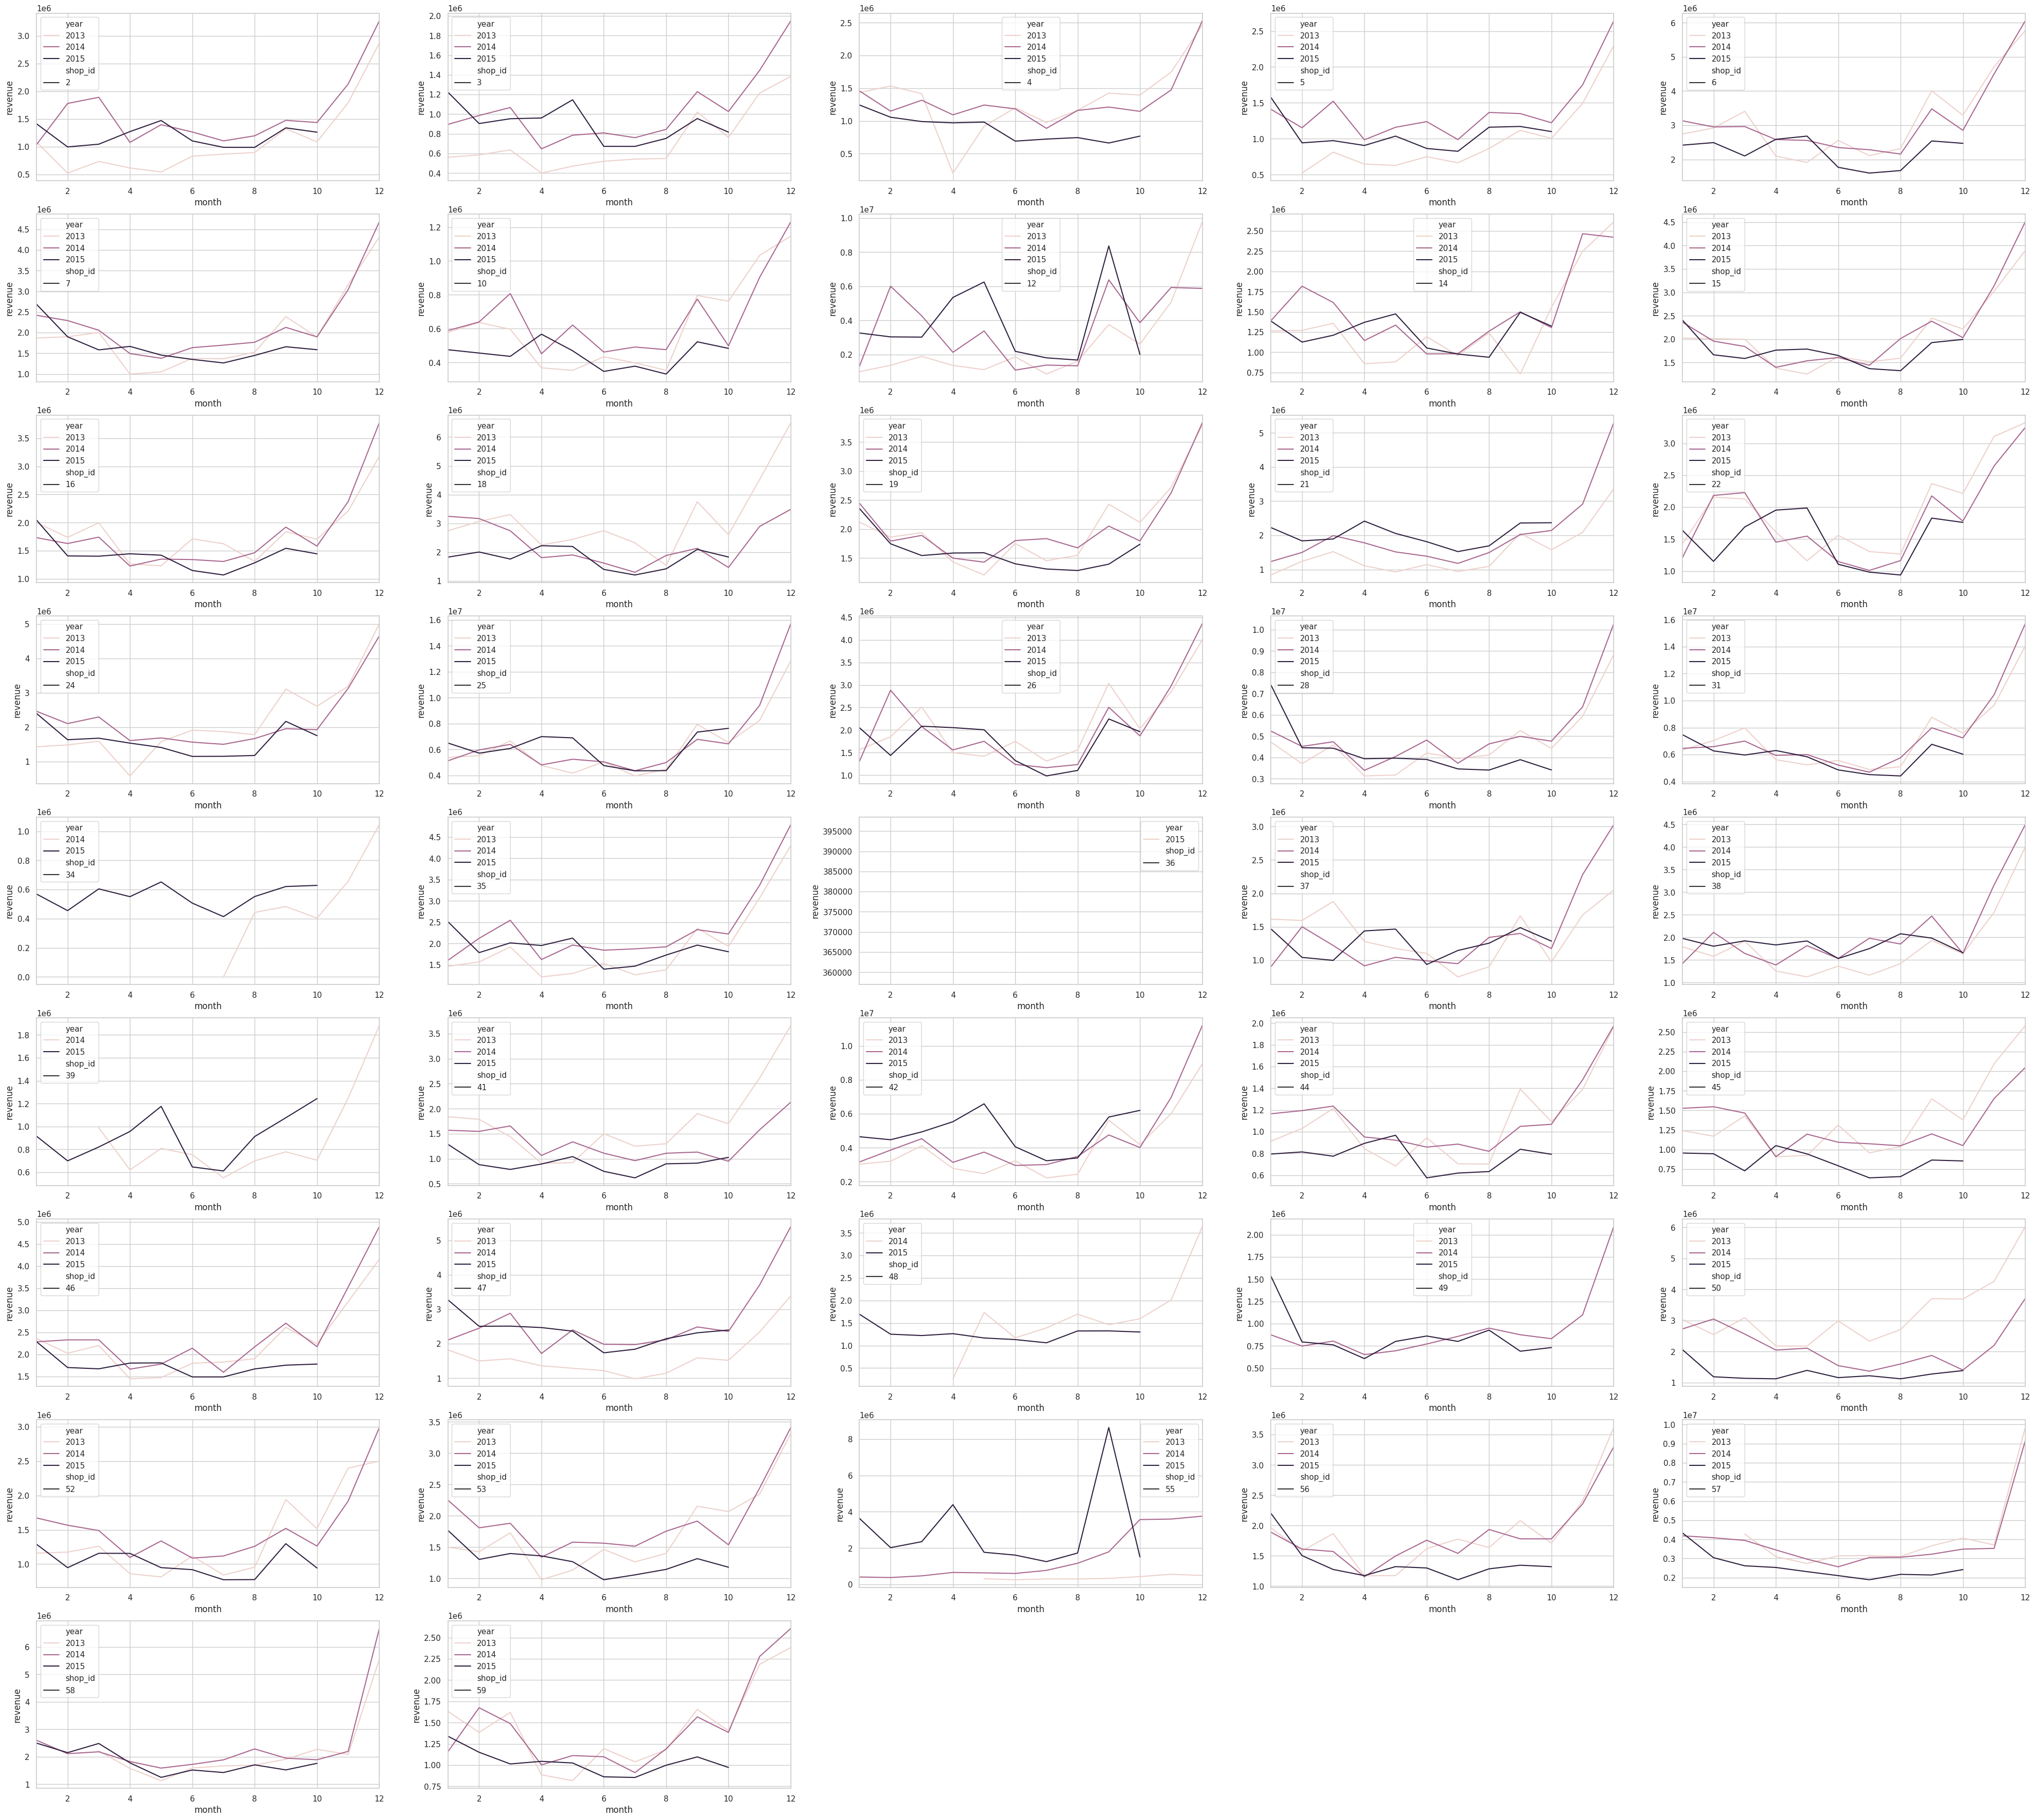

In [24]:
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(50, 50))

for i, j in enumerate(test.sort_values('shop_id').shop_id.unique()):
    temp = sales_agg[sales_agg['shop_id'] == j]
    fig = plt.subplot(10, 5, i+1)
    sns.lineplot(
        x = 'month',
        y = 'revenue',
        style = "shop_id",
        hue = 'year',
        ci = None,
        data = temp).set_xlim(1,12)

In [25]:
# duplicated shop names, change it for test and train
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [26]:
dataset = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    temp = train[train.date_block_num == i]
    dataset.append( np.array(list( product( [i], temp.shop_id.unique(), temp.item_id.unique() ) ), dtype = np.int16) )

dataset = pd.DataFrame( np.vstack(dataset), columns = cols )
dataset["date_block_num"] = dataset["date_block_num"].astype(np.int8)
dataset["shop_id"] = dataset["shop_id"].astype(np.int8)
dataset["item_id"] = dataset["item_id"].astype(np.int16)
dataset.sort_values( cols, inplace = True )
dataset.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [27]:
#Just getting all cnt info in month aggregation
item = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
item.columns = ['item_cnt_month']
item.reset_index(inplace=True)

dataset = pd.merge(dataset, item, on = ['date_block_num','shop_id','item_id'], how='left')
del(item)

#Filling target nans with 0
dataset["item_cnt_month"] = dataset["item_cnt_month"].fillna(0).clip(0,20).astype(np.float16)
dataset.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [28]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [29]:
dataset = pd.concat([dataset, test], ignore_index=True, sort=False, keys= ['date_block_num','shop_id','item_id'])
dataset.drop(['ID'], axis=1, inplace=True)
dataset.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [30]:
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']

#label encode these columns
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)
items.sample(10)

,item_id,category_id,item_name,item_name_first4,item_name_first6,item_name_first11
3982,3982,55,jamiroquai rock dust light star,1625,2800,5094
1565,1565,23,"assassin's creed: the outcast [xbox 360, russi...",349,533,867
15253,15253,63,"soft toy angry birds star wars 12,5cm hansolo",3039,5284,9453
12162,12162,63,"toy anti-stress ""masha and the bear"" 20 cm",3323,6014,10833
12633,12633,55,kozlov alexei & arsenal 13 selected works (com...,1762,3015,5475
6751,6751,30,"street fighter x tekken [pc, jewel, russian su...",3124,5465,9824
5510,5510,55,pitbull planet pit,2521,4284,7717
19282,19282,31,the doctors of the dungeons 2: the hunt for th...,3243,5716,10279
18582,18582,40,now the most time (region),2300,3962,7177
6176,6176,31,"royal quest royal edition [pc, digital version]",2771,4737,8484


In [31]:
dataset = pd.merge(dataset, items, on = 'item_id', how='left')
dataset = pd.merge(dataset, shops, on = 'shop_id', how='left')
dataset = pd.merge(dataset, cats, on = 'category_id', how='left')

dataset.drop('item_name', axis=1 , inplace = True)
dataset.drop('shop_name', axis=1 , inplace = True)
dataset.head()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype
0,0,2,19,0.0,40,17,20,20,Cinema,DVD
1,0,2,27,1.0,19,25,28,28,Games,PS3
2,0,2,28,0.0,30,25,28,28,PC Games,Standard Editions
3,0,2,29,0.0,23,25,28,28,Games,XBOX 360
4,0,2,32,0.0,40,26,29,29,Cinema,DVD


In [32]:
dataset['month'] = dataset['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
dataset['days'] = dataset['month'].map(days).astype(np.int8)

dataset['subtype'] = LabelEncoder().fit_transform(dataset['subtype'])
dataset['type'] = LabelEncoder().fit_transform(dataset['type'])
dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30


In [33]:
#Lagging label column
dataset = lag_feature( dataset, [1,2,3,6], "item_cnt_month" )
dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0


In [34]:
# make a mean by month
mean = dataset.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_item_cnt']
mean = mean.reset_index()
dataset = pd.merge(dataset, mean, on=['date_block_num'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3,6], "avg_by_month_item_cnt" )
dataset.drop(columns = ['avg_by_month_item_cnt'], axis = 1, inplace = True)
dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542


In [35]:
# mean by month / id
mean = dataset.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_item_id_item_cnt']
mean = mean.reset_index()
dataset = pd.merge(dataset, mean, on=['date_block_num', 'item_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3], "avg_by_month_item_id_item_cnt" )
dataset.drop(columns = ['avg_by_month_item_id_item_cnt'], axis = 1, inplace = True)
dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6,avg_by_month_item_id_item_cnt_lag_1,avg_by_month_item_id_item_cnt_lag_2,avg_by_month_item_id_item_cnt_lag_3
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.023256,0.071429
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN,0.022727,0.069767,NaN
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.113636,0.069767,0.095238
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.069767,0.166667
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.068182,0.116279,0.023810


In [36]:
# mean by month / shop
mean = dataset.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_shop_item_cnt']
mean = mean.reset_index()

dataset = pd.merge(dataset, mean, on=['date_block_num', 'shop_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1,2,3], "avg_by_month_shop_item_cnt" )
dataset.drop(columns = ['avg_by_month_shop_item_cnt'], axis = 1, inplace = True)
dataset.tail()


,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6,avg_by_month_item_id_item_cnt_lag_1,avg_by_month_item_id_item_cnt_lag_2,avg_by_month_item_id_item_cnt_lag_3,avg_by_month_shop_item_cnt_lag_1,avg_by_month_shop_item_cnt_lag_2,avg_by_month_shop_item_cnt_lag_3
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.023256,0.071429,0.126732,0.12881,0.138998
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN,0.022727,0.069767,NaN,0.126732,0.12881,NaN
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.113636,0.069767,0.095238,0.126732,0.12881,0.138998
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.069767,0.166667,0.126732,0.12881,0.138998
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.068182,0.116279,0.023810,0.126732,0.12881,0.138998


In [37]:
#mean by month / category
mean = dataset.groupby(['date_block_num', 'category_id']).agg({'item_cnt_month': ['mean']})
mean.columns = ['avg_by_month_cat_item_cnt']
mean = mean.reset_index()

dataset = pd.merge(dataset, mean, on=['date_block_num', 'category_id'], how='left')
del(mean)

#Lagging
dataset = lag_feature( dataset, [1], "avg_by_month_cat_item_cnt" )
dataset.drop(columns = ['avg_by_month_cat_item_cnt'], axis = 1, inplace = True)
dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6,avg_by_month_item_id_item_cnt_lag_1,avg_by_month_item_id_item_cnt_lag_2,avg_by_month_item_id_item_cnt_lag_3,avg_by_month_shop_item_cnt_lag_1,avg_by_month_shop_item_cnt_lag_2,avg_by_month_shop_item_cnt_lag_3,avg_by_month_cat_item_cnt_lag_1
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.023256,0.071429,0.126732,0.12881,0.138998,0.196845
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN,0.022727,0.069767,NaN,0.126732,0.12881,NaN,0.155870
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.113636,0.069767,0.095238,0.126732,0.12881,0.138998,0.196845
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.069767,0.166667,0.126732,0.12881,0.138998,0.220812
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.068182,0.116279,0.023810,0.126732,0.12881,0.138998,0.256864


In [38]:
price = train.groupby(['item_id']).agg({'item_price': ['mean']})
price.columns = ['avg_item_price']
price.reset_index(inplace=True)

dataset = pd.merge(dataset, price, on=['item_id'], how='left')
del(price)

# add price mean grouped by month and id
price = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
price.columns = ['avg_item_price_month']
price.reset_index(inplace=True)

dataset = pd.merge(dataset, price, on=['date_block_num','item_id'], how='left')
del(price)
gc.collect()

dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6,avg_by_month_item_id_item_cnt_lag_1,avg_by_month_item_id_item_cnt_lag_2,avg_by_month_item_id_item_cnt_lag_3,avg_by_month_shop_item_cnt_lag_1,avg_by_month_shop_item_cnt_lag_2,avg_by_month_shop_item_cnt_lag_3,avg_by_month_cat_item_cnt_lag_1,avg_item_price,avg_item_price_month
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.023256,0.071429,0.126732,0.12881,0.138998,0.196845,188.681084,NaN
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN,0.022727,0.069767,NaN,0.126732,0.12881,NaN,0.155870,1256.975000,NaN
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.113636,0.069767,0.095238,0.126732,0.12881,0.138998,0.196845,198.113208,NaN
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.069767,0.166667,0.126732,0.12881,0.138998,0.220812,98.096296,NaN
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.068182,0.116279,0.023810,0.126732,0.12881,0.138998,0.256864,502.297061,NaN


In [39]:
#lag month column to provide price for test set
lags = [1, 2, 3, 4, 5, 6]
dataset = lag_feature( dataset, lags, "avg_item_price_month" )
for i in lags:
    dataset["delta_price_lag_" + str(i) ] = (dataset["avg_item_price_month_lag_" + str(i)] - dataset["avg_item_price"] ) / dataset["avg_item_price"]

dataset["delta_price_lag"] = dataset.apply(select_trends, axis = 1)
dataset["delta_price_lag"] = dataset.delta_price_lag.astype( np.float16 )
dataset["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["avg_item_price_month", "avg_item_price"]
for i in lags:
    features_to_drop.append("avg_item_price_month_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
dataset.drop(features_to_drop, axis = 1, inplace = True)

dataset.tail()

,date_block_num,shop_id,item_id,item_cnt_month,category_id,item_name_first4,item_name_first6,item_name_first11,type,subtype,month,days,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,avg_by_month_item_cnt_lag_1,avg_by_month_item_cnt_lag_2,avg_by_month_item_cnt_lag_3,avg_by_month_item_cnt_lag_6,avg_by_month_item_id_item_cnt_lag_1,avg_by_month_item_id_item_cnt_lag_2,avg_by_month_item_id_item_cnt_lag_3,avg_by_month_shop_item_cnt_lag_1,avg_by_month_shop_item_cnt_lag_2,avg_by_month_shop_item_cnt_lag_3,avg_by_month_cat_item_cnt_lag_1,delta_price_lag
11128045,34,45,18454,NaN,55,2846,4919,8826,12,16,10,30,1.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.023256,0.071429,0.126732,0.12881,0.138998,0.196845,-0.475342
11128046,34,45,16188,NaN,64,522,886,1557,10,12,10,30,0.0,0.0,NaN,NaN,0.258565,0.263758,NaN,NaN,0.022727,0.069767,NaN,0.126732,0.12881,NaN,0.155870,0.081177
11128047,34,45,15757,NaN,55,2298,3960,7174,12,16,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.113636,0.069767,0.095238,0.126732,0.12881,0.138998,0.196845,0.155884
11128048,34,45,19648,NaN,40,3226,5639,10126,6,24,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.045455,0.069767,0.166667,0.126732,0.12881,0.138998,0.220812,-0.091736
11128049,34,45,969,NaN,37,102,139,205,6,11,10,30,0.0,0.0,0.0,0.0,0.258565,0.263758,0.287989,0.259542,0.068182,0.116279,0.023810,0.126732,0.12881,0.138998,0.256864,-0.605957


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 28 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   date_block_num                       int8   
 1   shop_id                              int8   
 2   item_id                              int16  
 3   item_cnt_month                       float16
 4   category_id                          int64  
 5   item_name_first4                     int64  
 6   item_name_first6                     int64  
 7   item_name_first11                    int64  
 8   type                                 int64  
 9   subtype                              int64  
 10  month                                int8   
 11  days                                 int8   
 12  item_cnt_month_lag_1                 float16
 13  item_cnt_month_lag_2                 float16
 14  item_cnt_month_lag_3                 float16
 15  item_cnt_month_lag_6          

In [40]:
dataset.to_pickle('dataset.pickle')
test.to_pickle('test.pickle')

In [43]:
df = pd.read_pickle('dataset.pickle')

X_train = df[~df.date_block_num.isin([0,1,33,34])]
y_train = X_train['item_cnt_month']
del X_train['item_cnt_month']

X_val = df[df['date_block_num']==33]
y_val = X_val['item_cnt_month']
del X_val['item_cnt_month']

X_test = df[df['date_block_num']==34].drop(columns='item_cnt_month')
X_test = X_test.reset_index()
del X_test['index']

#free memory
del df

In [48]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), categorical_feature=cat_features)
    return model

In [52]:
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}

cat_features = ['category_id','month','shop_id']

lgb_model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)

lgb_model.save_model('initial_lgb_model.txt')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.380286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 9934775, number of used features: 27
[LightGBM] [Info] Start training from score 0.296403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[401]	training's rmse: 0.719664	valid_1's rmse: 0.891331


In [54]:
lgb_model = lgb.Booster(model_file='initial_lgb_model.txt')
lgb_model.params['objective'] = 'rmse'

In [56]:
submission = pd.read_csv('sample_submission.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('initial_lgb_submission.csv', index=False)

In [57]:
 submission.head()

,ID,item_cnt_month
0,0,0.373144
1,1,0.799284
2,2,0.933562
3,3,0.436237
4,4,1.142160


In [59]:
submission.to_csv('submission.csv', index=False)